<a href="https://colab.research.google.com/github/david91107/predict_sklearn/blob/main/DTC_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Prepare Enviornment

#### Install Libraries

In [ ]:
# Install libraries

!pip install --upgrade pip
!pip install pandas==1.5.3 # to be compatible with google-colab 1.0.0
!pip install matplotlib
!pip install shap

#### Import Methods

In [ ]:
# Import necessary methods

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Ignore FutureWarning

import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
from statsmodels.stats.outliers_influence import variance_inflation_factor

from scipy.stats import f_oneway

from sklearn.utils import shuffle

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
import shap as shap
from shap import TreeExplainer, summary_plot


## Ingest Data

In [ ]:
# Load CSV data file into a dataframe

df_pre = pd.read_csv(r'/content/drive/MyDrive/Data_sets/telco_subscription_data.csv')

In [ ]:
# Check data load

df_pre.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134575 entries, 0 to 134574
Data columns (total 15 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   random_key                 134575 non-null  int64  
 1   target                     134575 non-null  int64  
 2   customer_demo_age          134575 non-null  int64  
 3   customer_demo_geography_1  134575 non-null  int64  
 4   customer_demo_geography_2  134575 non-null  int64  
 5   sales_channel              134575 non-null  int64  
 6   sales_team                 134575 non-null  int64  
 7   sales_program              134575 non-null  int64  
 8   product_sku                134575 non-null  int64  
 9   product_cpe                134575 non-null  int64  
 10  product_operations_kpi1    132071 non-null  float64
 11  product_operations_kpi2    134575 non-null  int64  
 12  product_usage_kpi1         134575 non-null  int64  
 13  product_usage_kpi2         13

## Data Cleansing

In [ ]:
# Look for Null values

print('Null count')
print(df_pre.isnull().sum())

print()

# Look for NaN values
print('NaN count')
print(df_pre.isna().sum())

Null count
random_key                      0
target                          0
customer_demo_age               0
customer_demo_geography_1       0
customer_demo_geography_2       0
sales_channel                   0
sales_team                      0
sales_program                   0
product_sku                     0
product_cpe                     0
product_operations_kpi1      2504
product_operations_kpi2         0
product_usage_kpi1              0
product_usage_kpi2              0
product_usage_kpi3              0
dtype: int64

NaN count
random_key                      0
target                          0
customer_demo_age               0
customer_demo_geography_1       0
customer_demo_geography_2       0
sales_channel                   0
sales_team                      0
sales_program                   0
product_sku                     0
product_cpe                     0
product_operations_kpi1      2504
product_operations_kpi2         0
product_usage_kpi1              0
product_usage

In [ ]:
# Drop Nulls

df_pre.dropna(inplace=True)

In [ ]:
# Check for any duplication

print("Number of duplicate rows:", df_pre.duplicated().sum())

Number of duplicate rows: 0


In [ ]:
# Drop random_key

df_pre.drop(columns='random_key', inplace=True)

In [ ]:
# Some of the int values are actually string values
# that will need to be flattened

columns_to_cast = ['sales_team', 'sales_channel','sales_program','product_sku','product_cpe','customer_demo_geography_1','customer_demo_geography_2']

df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(object)

In [ ]:
# Some of the float64 values are actually int values
# that will need to be flattened

# Define a list of column names that you want to cast
columns_to_cast = ['product_operations_kpi1']

# Cast the specified columns to the desired data type (object in this case)
df_pre[columns_to_cast] = df_pre[columns_to_cast].astype(int)

In [ ]:
# Count distinct values for categorical features

features_categorical = ['product_sku','customer_demo_geography_2','customer_demo_geography_1','sales_channel','product_cpe','sales_program','sales_team']

for feature in features_categorical:
  unique_values = df_pre[feature].nunique()
  print(feature, unique_values)

product_sku 3
customer_demo_geography_2 5307
customer_demo_geography_1 50
sales_channel 4
product_cpe 18
sales_program 20
sales_team 22


In [ ]:
# Drop categories with a high unique value count until an ANOVA check

feature_high_count = ['customer_demo_geography_2']
df_pre.drop(columns=feature_high_count, inplace=True)

## Explority Data Analysis

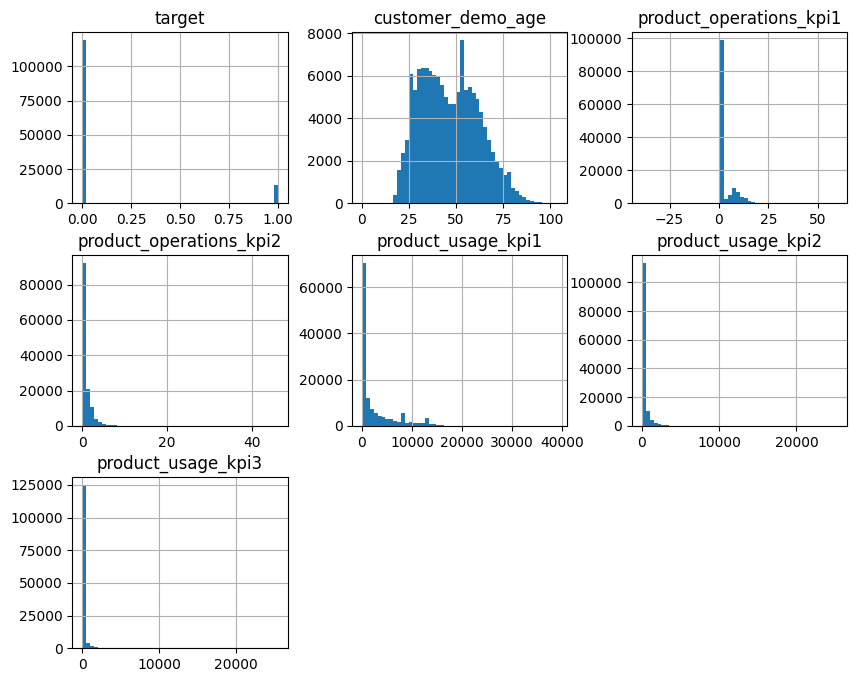

In [ ]:
# Exploratory plots

df_pre.hist(bins=50, figsize=(10, 8))
plt.show()

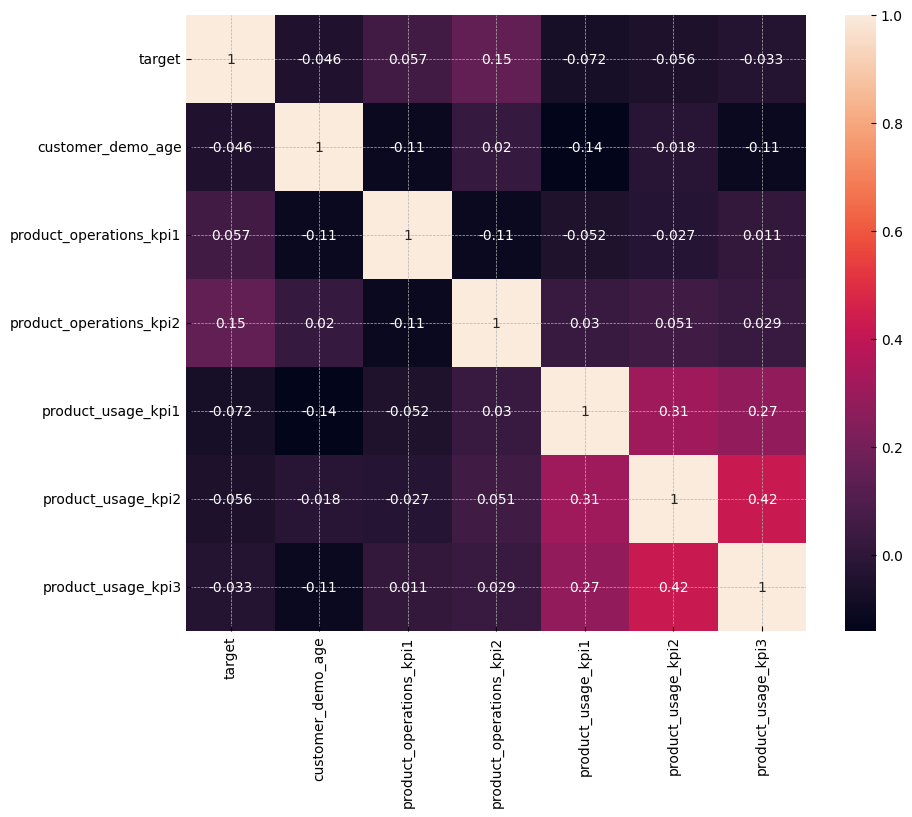

In [ ]:
# Collinearity: Pearson

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

corrMatrix = df_num.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [ ]:
# Collinearity: VIF

df_num = df_pre.select_dtypes(include = ['float64', 'int64'])

# Calculate VIF for each numeric feature
vif = pd.DataFrame()
vif["Feature"] = df_num.columns
vif["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]

# Print the VIF values to identify multicollinearity among numeric features
print("VIF Values for Numeric Features:")
print(vif)

VIF Values for Numeric Features:
                   Feature       VIF
0                   target  1.136787
1        customer_demo_age  1.996267
2  product_operations_kpi1  1.461237
3  product_operations_kpi2  1.245531
4       product_usage_kpi1  1.564750
5       product_usage_kpi2  1.536754
6       product_usage_kpi3  1.363380


## Prepare Dataset

In [ ]:
# Normalize continuous features

columns_to_norm = ['product_usage_kpi1','product_usage_kpi2', 'product_usage_kpi3','product_operations_kpi1','product_operations_kpi2']

for column in columns_to_norm:
  df_pre[column] = df_pre[column] / df_pre[column].abs().max()

In [ ]:
# Bin age into generations
# Assumption is that trends fall along generations
# https://www.beresfordresearch.com/age-range-by-generation/
# gen_z = 12 to 27
# millennial = 28 to 43
# gen_x = 44 to 59
# boomers = 60 to 78
# post_war = 79 to 96

df_pre['customer_demo_age_gen'] = df_pre['customer_demo_age'].apply(lambda age:
    'gen_z' if age >= 12 and age <= 27 else
    'millennial' if age >= 28 and age <= 43 else
    'gen_x' if age >= 44 and age <= 59 else
    'boomers' if age >= 60 and age <= 78 else
    'post_war' if age >= 79 and age <= 96 else
    'invalid' if age < 18 and age > 99 else
    'other'
)

# Drop age
df_pre.drop('customer_demo_age', axis=1, inplace=True)

In [ ]:
# Flatten categorical features

categorical_features = ['product_sku','sales_channel','sales_team','product_cpe','sales_program','customer_demo_age_gen','customer_demo_geography_1']

# Perform one-hot encoding (flattening) of the specified columns
df_pre = pd.get_dummies(df_pre, columns=categorical_features)

# Convert boolean values to integers (1 and 0)
df_pre = df_pre.astype(int)

### Feature Reduction

In [ ]:
# Pre-reduction feature data

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)

print(f"Total Unique Column Names: {column_count}")
print()
for column, dtype in df_pre.dtypes.items():
    print(f'Column: {column}, Data Type: {dtype}')

Total Unique Column Names: 129

Column: target, Data Type: int64
Column: product_operations_kpi1, Data Type: int64
Column: product_operations_kpi2, Data Type: int64
Column: product_usage_kpi1, Data Type: int64
Column: product_usage_kpi2, Data Type: int64
Column: product_usage_kpi3, Data Type: int64
Column: product_sku_0, Data Type: int64
Column: product_sku_1, Data Type: int64
Column: product_sku_2, Data Type: int64
Column: sales_channel_0, Data Type: int64
Column: sales_channel_1, Data Type: int64
Column: sales_channel_2, Data Type: int64
Column: sales_channel_3, Data Type: int64
Column: sales_team_0, Data Type: int64
Column: sales_team_1, Data Type: int64
Column: sales_team_2, Data Type: int64
Column: sales_team_3, Data Type: int64
Column: sales_team_4, Data Type: int64
Column: sales_team_5, Data Type: int64
Column: sales_team_6, Data Type: int64
Column: sales_team_7, Data Type: int64
Column: sales_team_8, Data Type: int64
Column: sales_team_9, Data Type: int64
Column: sales_team_10,

In [ ]:
# Reduce features to those that are most statistically significant

# Define the target variable (column 1)
target_variable = 'target'

# Perform ANOVA tests for each feature
alpha = 0.05

# Initialize a list to store ANOVA results
anova_results = []

for feature_column in df_pre.columns[2:]:
  f_statistic, p_value = f_oneway(df_pre[feature_column], df_pre[target_variable])
  if p_value >= alpha:
    significance = 'Not Significant'
    df_pre.drop(columns=feature_column, inplace=True)

  else:
    significance = 'Significant'

  anova_results.append([feature_column, f_statistic, p_value, significance])

# Create a DataFrame from the ANOVA results
df_anova = pd.DataFrame(anova_results, columns=['Feature', 'F-statistic', 'P-value', 'Significance'])
df_filtered_not_sig = df_anova[df_anova['Significance'] == 'Not Significant'][['Feature', 'Significance']]

In [ ]:
# Feature count after reduction

unique_column_names = set(df_pre.columns)
column_count = len(unique_column_names)

print(f"Total Unique Column Names: {column_count}")
print()
for column, dtype in df_pre.dtypes.items():
    print(f'Column: {column}, Data Type: {dtype}')

Total Unique Column Names: 127

Column: target, Data Type: int64
Column: product_operations_kpi1, Data Type: int64
Column: product_operations_kpi2, Data Type: int64
Column: product_usage_kpi1, Data Type: int64
Column: product_usage_kpi2, Data Type: int64
Column: product_usage_kpi3, Data Type: int64
Column: product_sku_0, Data Type: int64
Column: product_sku_1, Data Type: int64
Column: product_sku_2, Data Type: int64
Column: sales_channel_0, Data Type: int64
Column: sales_channel_1, Data Type: int64
Column: sales_channel_2, Data Type: int64
Column: sales_channel_3, Data Type: int64
Column: sales_team_0, Data Type: int64
Column: sales_team_1, Data Type: int64
Column: sales_team_2, Data Type: int64
Column: sales_team_3, Data Type: int64
Column: sales_team_4, Data Type: int64
Column: sales_team_5, Data Type: int64
Column: sales_team_6, Data Type: int64
Column: sales_team_8, Data Type: int64
Column: sales_team_9, Data Type: int64
Column: sales_team_10, Data Type: int64
Column: sales_team_11

## Create Model

### Prepare data set for DTC algorithm

In [ ]:
# For Decision Tree Classifier

df_dtc = df_pre.copy()

In [ ]:
#Create Decision Tree classifer object

from sklearn.tree import DecisionTreeClassifier

model_dtc = DecisionTreeClassifier()

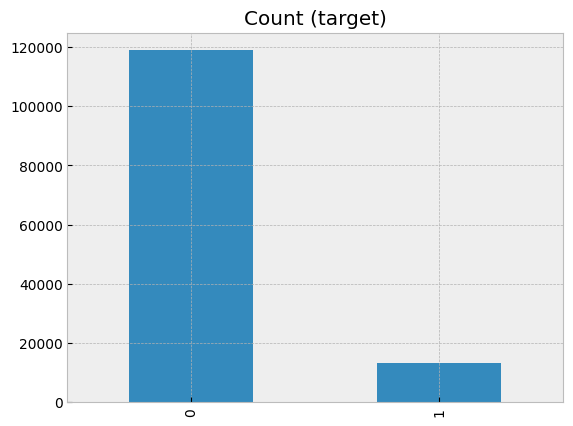

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Address class imbalance of the target

df_dtc.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

Random over-sampling:
0    118901
1    118901
Name: target, dtype: int64


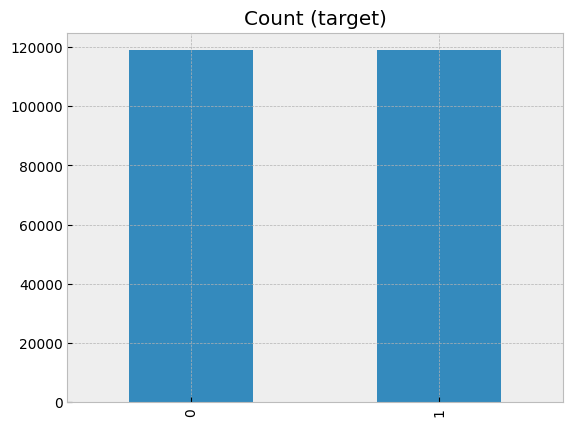

<Figure size 1000x800 with 0 Axes>

In [ ]:
# Oversample the minority class using "random over sampling"
# This linear approach supports cleaner interpetation of
# feature importance with SHAP.

count_class_0, count_class_1 = df_dtc.target.value_counts()

# Divide by class
df_class_0 = df_dtc[df_dtc['target'] == 0] #majority class
df_class_1 = df_dtc[df_dtc['target'] == 1] #minority class

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_over = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_over.target.value_counts())

df_over.target.value_counts().plot(kind='bar', title='Count (target)')

plt.style.use('bmh')
plt.figure(figsize=(10, 8))

plt.show()

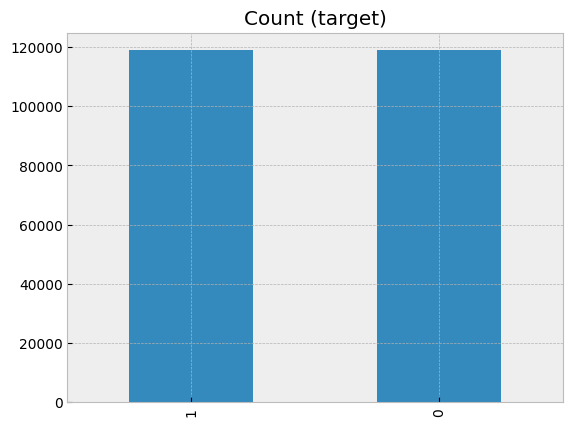

In [ ]:
# Shuffle the array before train/test split

df_over = shuffle(df_over,random_state=0)
df_over.target.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
# Train/test splits

X, y = df_over, df_over.pop("target")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42) # Small test size only to support feature reduction via SHAP

In [ ]:
# Fit and score the model

#model_dtc.fit(X_train, y_train.values.ravel())
model_dtc.fit(X_train, y_train.values)
score_train = model_dtc.score(X_train, y_train)
print("score_train: ", score_train)
print(X_train.shape, y_train.shape)

score_train:  0.7956969000859867
(159327, 126) (159327,)


In [ ]:
# Confusion matrix

y_pred = model_dtc.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.82      0.72      0.77     39202
           1       0.75      0.84      0.79     39273

    accuracy                           0.78     78475
   macro avg       0.79      0.78      0.78     78475
weighted avg       0.79      0.78      0.78     78475



>1, train: 0.718, test: 0.719
>2, train: 0.736, test: 0.734
>3, train: 0.744, test: 0.744
>4, train: 0.747, test: 0.747
>5, train: 0.749, test: 0.749
>6, train: 0.751, test: 0.750
>7, train: 0.753, test: 0.752
>8, train: 0.756, test: 0.754
>9, train: 0.760, test: 0.757
>10, train: 0.762, test: 0.760
>11, train: 0.765, test: 0.762
>12, train: 0.767, test: 0.763
>13, train: 0.769, test: 0.764
>14, train: 0.771, test: 0.767


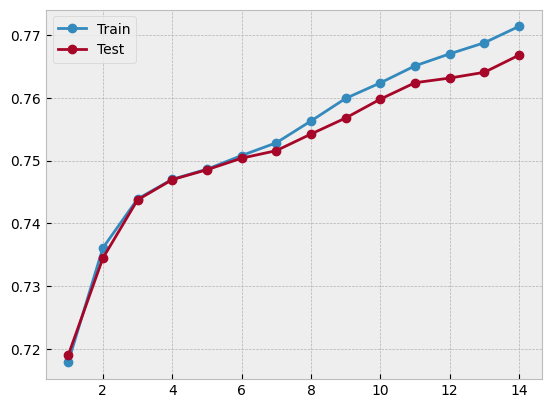

In [ ]:
# Look for any overfitting of the DTC model

# Define the tree depths to evaluate
values = [i for i in range(1, 15)]

# Define lists to collect scores
train_scores, test_scores = list(), list()

# Evaluate for each depth
for i in values:

  # configure the model
  model_dtc = DecisionTreeClassifier(max_depth=i)

    # fit model on the training dataset
  model_dtc.fit(X_train, y_train)

  # evaluate on the train dataset
  train_yhat = model_dtc.predict(X_train)
  train_acc = accuracy_score(y_train, train_yhat)
  train_scores.append(train_acc)

  # evaluate on the test dataset
  test_yhat = model_dtc.predict(X_test)
  test_acc = accuracy_score(y_test, test_yhat)
  test_scores.append(test_acc)

# summarize progress
  print('>%d, train: %.3f, test: %.3f' % (i, train_acc, test_acc))

# plot of train and test scores vs tree depth
plt.plot(values, train_scores, '-o', label='Train')
plt.plot(values, test_scores, '-o', label='Test')
plt.legend()
plt.show()

In [ ]:
# Get model parameters

model = DecisionTreeClassifier()
for parameter in model.get_params():
    print(parameter)

ccp_alpha
class_weight
criterion
max_depth
max_features
max_leaf_nodes
min_impurity_decrease
min_samples_leaf
min_samples_split
min_weight_fraction_leaf
random_state
splitter


In [ ]:
# Set hyper-parameter dictionary to tune the model
# and resolve any overfitting

param_dict = {"criterion" :["gini", "entropy"],
            "max_depth" :range(1,10),
            #"min_samples_split" :range(2,10),
            #"min_samples_leaf" :range(1,5),
             "ccp_alpha" :[0.0001, 0.001, 0.01]}

tree_class = DecisionTreeClassifier()

grid = GridSearchCV(estimator=tree_class,
        param_grid = param_dict,
        cv = 10,
        verbose= 1,
        n_jobs = 1)

grid.fit(X_train, y_train)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'ccp_alpha': [0.0001, 0.001, 0.01],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10)},
             verbose=1)

In [ ]:
# Extact the best preforming tested parameter values

grid.best_params_

{'ccp_alpha': 0.0001, 'criterion': 'entropy', 'max_depth': 9}

In [ ]:
# Update model

model_dtc_p=DecisionTreeClassifier(ccp_alpha = 0.0001,
                                   criterion ='entropy',
                                   max_depth = 9)

In [ ]:
#Fit and re-score the model

model_dtc_p.fit(X_train, y_train.values.ravel())
score_train = model_dtc_p.score(X_test, y_test)
print("score_train: ", score_train)

score_train:  0.7549538069448869


In [ ]:
# Confusion matrix

y_pred = model_dtc_p.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.79      0.70      0.74     39202
           1       0.73      0.81      0.77     39273

    accuracy                           0.75     78475
   macro avg       0.76      0.75      0.75     78475
weighted avg       0.76      0.75      0.75     78475



Churn: ROC AUC=0.500
Logistic: ROC AUC=0.832


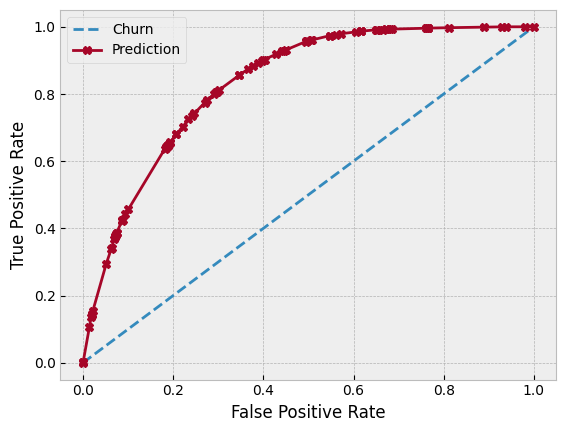

In [ ]:
# ROC curve and AUC

# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]

# predict probabilities
lr_probs = model_dtc_p.predict_proba(X_test)

# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('Churn: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Churn')
plt.plot(lr_fpr, lr_tpr, marker='X', label='Prediction')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

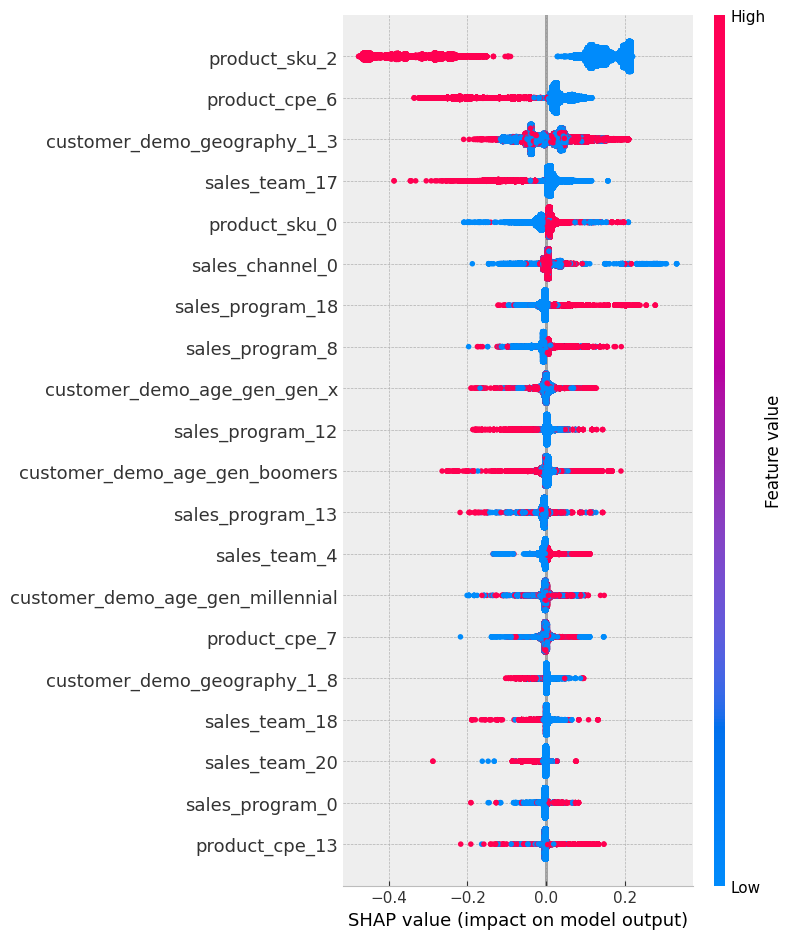

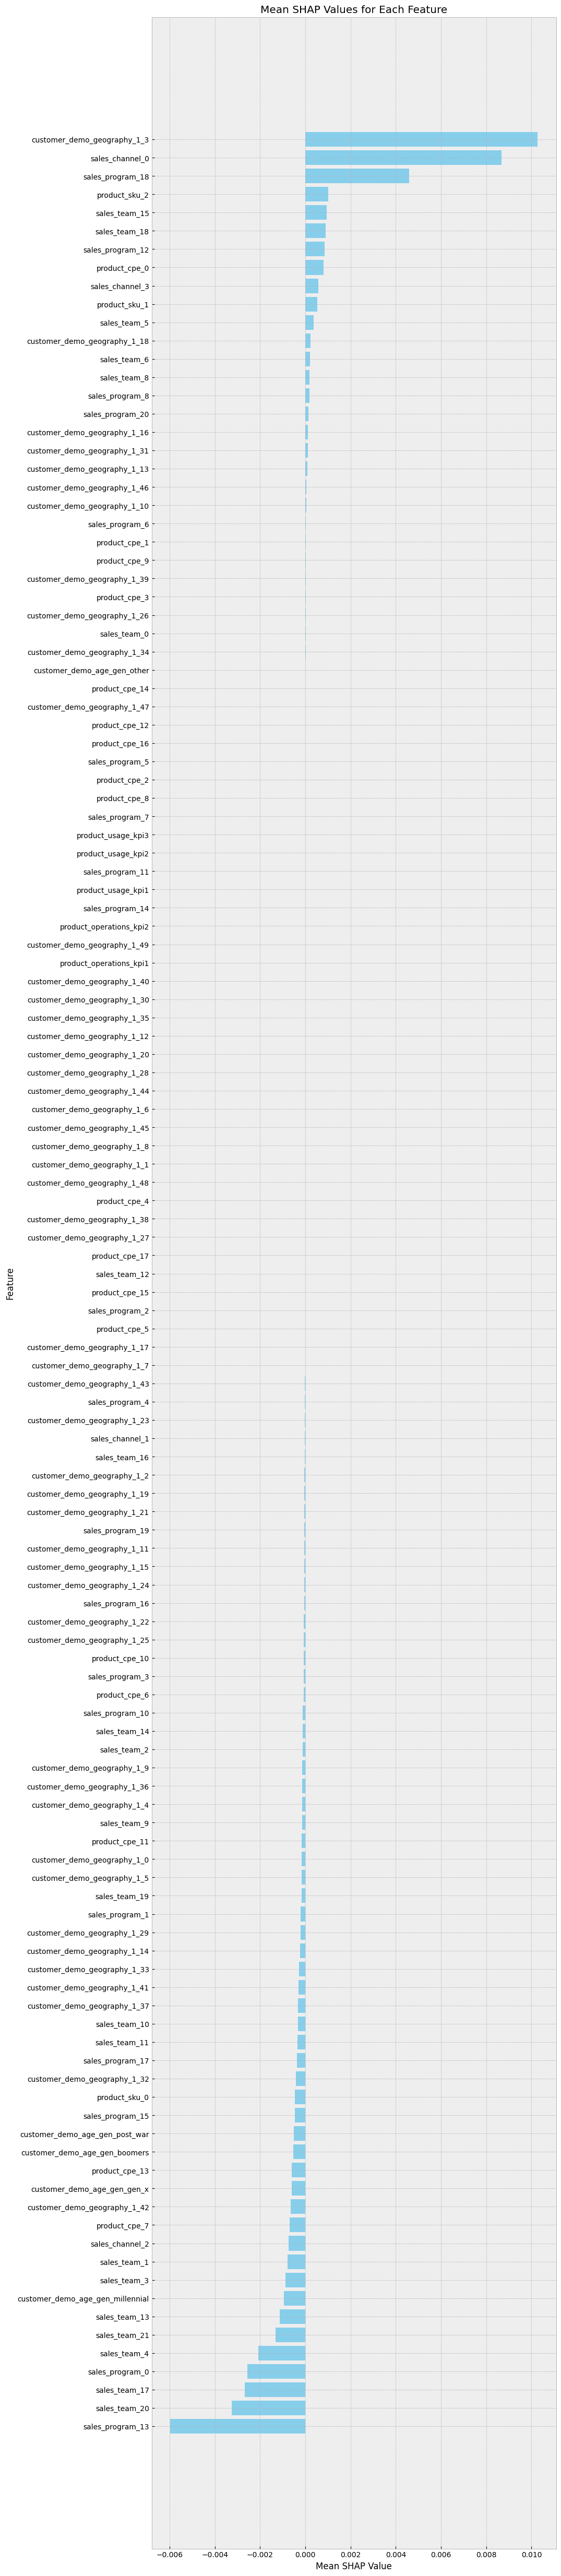

                        Feature  Min SHAP Value  Mean SHAP Value  \
63             sales_program_13       -0.218699        -0.005977   
31                sales_team_20       -0.287813        -0.003244   
28                sales_team_17       -0.386531        -0.002667   
51              sales_program_0       -0.191097        -0.002553   
16                 sales_team_4       -0.134456        -0.002087   
..                          ...             ...              ...   
26                sales_team_15       -0.182815         0.000948   
7                 product_sku_2       -0.476675         0.001017   
68             sales_program_18       -0.122321         0.004587   
8               sales_channel_0       -0.187425         0.008678   
79  customer_demo_geography_1_3       -0.209627         0.010277   

    Max SHAP Value  
63        0.144746  
31        0.076414  
28        0.157390  
51        0.082733  
16        0.111549  
..             ...  
26        0.167259  
7         0.220

In [ ]:
# Print Global SHAP values

exp = TreeExplainer(model_dtc)
sv = exp.shap_values(X_test)

# Initialize an empty list to store feature statistics
feature_stats = []
feature_to_drop = []

# Loop through each feature and calculate min, mean, and max SHAP values
for i in range(len(X_test.columns)):
    feature_name = X_test.columns[i]
    shap_values_feature = sv[1][:, i]
    min_val = np.min(shap_values_feature)
    mean_val = np.mean(shap_values_feature)
    max_val = np.max(shap_values_feature)
    feature_stats.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped


    # Append the statistics to the list of features to drop
    # if 1==1:#not (min_val == mean_val == max_val == 0):
    if (min_val == mean_val == max_val == 0):
        feature_to_drop.append([feature_name, min_val, mean_val, max_val]) # capture which features were dropped

# Create a DataFrames of all feature with their min, mean, max values
feature_stats_df = pd.DataFrame(feature_stats, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_stats.csv'

# Save the DataFrame to the specified path as a CSV file
feature_stats_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Create a DataFrames of dropped features
feature_to_drop_df = pd.DataFrame(feature_to_drop, columns=['Feature', 'Min SHAP Value', 'Mean SHAP Value', 'Max SHAP Value'])

# Load CSV file to the specified path
csv_path = '/content/drive/MyDrive/Colab Notebooks/sklearn/feature_to_drop_df.csv'

# Save the DataFrame to the specified path as a CSV file
feature_to_drop_df.to_csv(csv_path, index=False)  # Set index=False to avoid saving the index column


# Plots
# Display the SHAP summary plot for all features
shap.summary_plot(sv[1], X_test, max_display=20)

# Plotting the mean SHAP values for each feature
plt.figure(figsize=(10, len(feature_stats_df) / 2))  # Adjust the figure size as needed
feature_stats_df.sort_values(by='Mean SHAP Value', ascending=True, inplace=True)
plt.barh(feature_stats_df['Feature'], feature_stats_df['Mean SHAP Value'], color='skyblue')
plt.xlabel('Mean SHAP Value')
plt.ylabel('Feature')
plt.title('Mean SHAP Values for Each Feature')
plt.show()

print(feature_stats_df)


<Figure size 4000x1000 with 0 Axes>

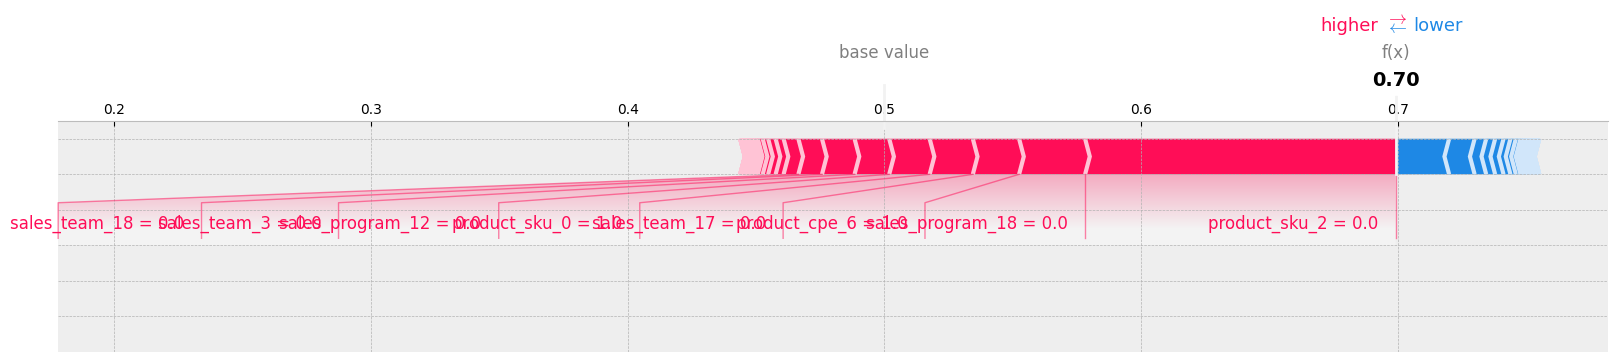

In [ ]:
# Force Plot visualization: single customer (Local SHAP values)

# Calculate SHAP values for the first row of the X_test dataset
shap_values_single = exp.shap_values(X_test.iloc[6])

# Initialize JavaScript visualization in Google Colab (even if it might not display)
shap.initjs()

# Generate a force plot using matplotlib backend
plt.figure(figsize=(40, 10))  # You can adjust the size as needed
shap.force_plot(exp.expected_value[1], shap_values_single[1], X_test.iloc[0], feature_names=X_test.columns, matplotlib=True)
plt.show()


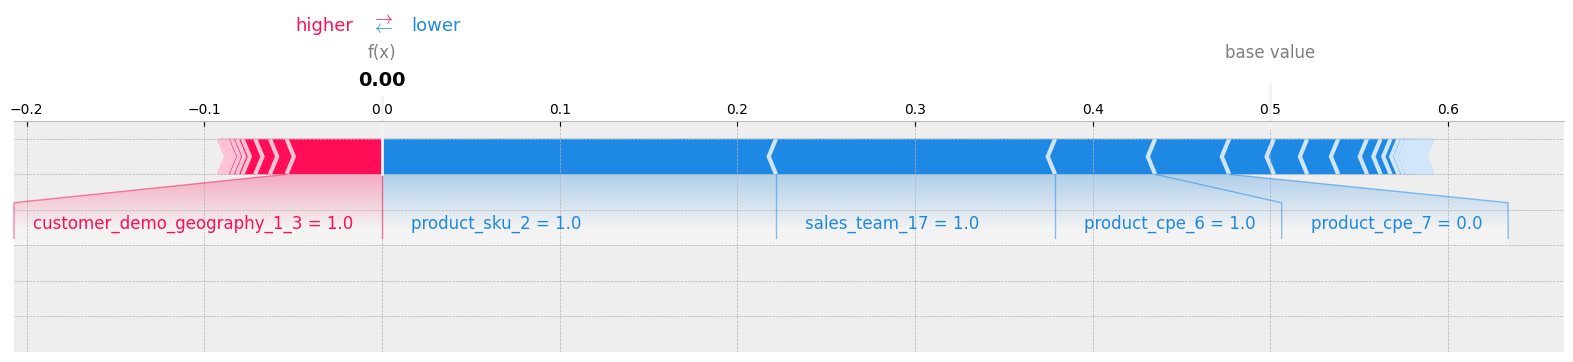

In [ ]:
# Filter customers based on all specified features and values simultaneously

high_value_features = {"product_sku_2": 1,
                       "product_cpe_6": 1,
                       "customer_demo_geography_1_3": 1
                       }

filtered_customers = X_test.copy()

for feature, value in high_value_features.items():
    filtered_customers = filtered_customers[filtered_customers[feature] == value]

# DataFrame to store SHAP values
shap_values_df = pd.DataFrame()

# Iterate over filtered customers to calculate SHAP values and generate force plots
for index, row in filtered_customers.iterrows():
    # Calculate SHAP values for the current example
    shap_values_example = exp.shap_values(row)

    # Append the SHAP values to the DataFrame
    shap_row_df = pd.DataFrame([shap_values_example[1]], columns=[f'shap_{col}' for col in X_test.columns])
    shap_values_df = pd.concat([shap_values_df, shap_row_df], ignore_index=True)

    # Generate a force plot for the example
    shap.initjs()
    shap.force_plot(exp.expected_value[1], shap_values_example[1], row, matplotlib=True)
    plt.show()

# Concatenate the SHAP values DataFrame with the filtered customers DataFrame
final_df = pd.concat([filtered_customers.reset_index(drop=True), shap_values_df], axis=1)

# Export to CSV
final_df.to_csv('shap_values.csv', index=False)